# Oak Wilt Spatiotemporal Clustering Playbook

## 1. Setup and Imports

In [1]:
import os
import json
import warnings
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyproj import Transformer
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ Core libraries imported and plotting style configured')

✓ Core libraries imported and plotting style configured


### Workflow Overview
- prepare cleaned oak wilt inspection data
- derive spatial (meters) and temporal features
- search DBSCAN parameters that yield many compact clusters spanning ≥2 unique years
- compute per-cluster metrics (centroid, radius, annual counts, spread rates) for modeling
- export machine-learning-ready datasets and produce diagnostic visuals

### How to Use This Notebook
- Edit the next cell to adjust clustering thresholds, fallback behavior, plotting, and export toggles.
- Run cells in order (Sections 1 → 9). Each section announces if prerequisites are missing.
- If a section prints ⚠️ guidance, address it before continuing to keep downstream outputs in sync.
- Use the data-quality signals (Section 2b) to decide whether to relax parameters.

In [2]:
CONFIG: Dict[str, object] = {
    'min_samples': 3,
    'min_unique_years': 2,
    'temporal_scale_factors': [0.2, 0.3, 0.4, 0.5],
    'temporal_scale_floor_m': 20.0,
    'temporal_scale_override_m': [20.0, 25.0, 30.0],  
    'eps_nn_percentiles': [30, 40, 50, 60, 70],
    'eps_floor_m': 15.0,
    'eps_candidates_override_m': [25.0, 35.0, 50.0, 65.0, 80.0], 
    'fallback_policies': [
        {'label': 'Relax unique-year requirement to 1', 'min_unique_years': 1},
        {'label': 'Drop min_samples by 1 (keep 2 years)', 'min_samples_delta': -1},
        {'label': 'Drop min_samples by 1 and relax unique-year to ≥1', 'min_samples_delta': -1, 'min_unique_years': 1}
    ],
    'min_samples_floor': 3,
    'plots_enabled': True,
    'exports_enabled': True,
    'diagnostics_preview_rows': 5
}

CURRENT_RUN: Dict[str, object] = {}

def show_active_config(config_dict: Dict[str, object]) -> None:
    """Pretty-print the current configuration so tweaks are visible before running."""
    print('Active configuration — adjust values in Cell 5 to explore alternatives:')
    simple_keys = [
        'min_samples', 'min_unique_years', 'temporal_scale_factors', 'temporal_scale_floor_m',
        'temporal_scale_override_m', 'eps_nn_percentiles', 'eps_floor_m', 'eps_candidates_override_m',
        'plots_enabled', 'exports_enabled'
    ]
    for key in simple_keys:
        print(f"  {key}: {config_dict[key]}")
    print('Fallback policies:')
    for idx, policy in enumerate(config_dict['fallback_policies'], start=1):
        print(f"  {idx}. {policy}")

show_active_config(CONFIG)

Active configuration — adjust values in Cell 5 to explore alternatives:
  min_samples: 3
  min_unique_years: 2
  temporal_scale_factors: [0.2, 0.3, 0.4, 0.5]
  temporal_scale_floor_m: 20.0
  temporal_scale_override_m: [20.0, 25.0, 30.0]
  eps_nn_percentiles: [30, 40, 50, 60, 70]
  eps_floor_m: 15.0
  eps_candidates_override_m: [25.0, 35.0, 50.0, 65.0, 80.0]
  plots_enabled: True
  exports_enabled: True
Fallback policies:
  1. {'label': 'Relax unique-year requirement to 1', 'min_unique_years': 1}
  2. {'label': 'Drop min_samples by 1 (keep 2 years)', 'min_samples_delta': -1}
  3. {'label': 'Drop min_samples by 1 and relax unique-year to ≥1', 'min_samples_delta': -1, 'min_unique_years': 1}


## 2. Load and Prepare Data

In [3]:
# Load cleaned inspection data
data_path = Path('../data/data_cleaned.csv')
if not data_path.exists():
    raise FileNotFoundError(f'Data file not found: {data_path.resolve()}')

df = pd.read_csv(data_path)

# Parse inspection dates so downstream summaries can use datetime-safe operations
df['INSPECTION_DATE'] = pd.to_datetime(df['INSPECTION_DATE'], format='%m/%d/%y', errors='coerce')

# Filter for confirmed oak wilt cases with valid spatiotemporal data
df_confirmed = df[
    (df['OAK_WILT_CONFIRMED'].str.lower() == 'yes') &
    (df['LATITUDE'].notna()) &
    (df['LONGITUDE'].notna()) &
    (df['INSPECTION_YEAR'].notna())
].copy()

df_confirmed['INSPECTION_YEAR'] = df_confirmed['INSPECTION_YEAR'].astype(int)

print(f'✓ Loaded {len(df):,} total records ({len(df_confirmed):,} confirmed with coordinates)')
print(f"✓ Inspection years available: {df_confirmed['INSPECTION_YEAR'].min()} to {df_confirmed['INSPECTION_YEAR'].max()}")
print(f"✓ Unique counties (if present): {df_confirmed['COUNTY'].nunique() if 'COUNTY' in df_confirmed.columns else 'N/A'}")

df_confirmed.head()

✓ Loaded 1,672 total records (1,672 confirmed with coordinates)
✓ Inspection years available: 1986 to 2024
✓ Unique counties (if present): N/A


,Inspection_ID (unique),MORTALITY_CENTER_ID,INSPECTION_DATE,INSPECTION_DECADE,INSPECTION_YEAR,SPECIES,LATITUDE,LONGITUDE,LANDOWNER_TYPE,OAK_WILT_CONFIRMED,SYMPTOM_VEINAL_NECROSIS,SYMPTOM_MORTALITY_PATTERN
0,NaN,5758.0,1986-08-24,1980s,1986,Live Oak,30.318636,-97.766907,Unknown,Yes,NaN,NaN
1,NaN,5723.0,1987-03-11,1980s,1987,Live Oak,30.263226,-97.804992,Unknown,Yes,Yes,NaN
2,NaN,5782.0,1988-03-17,1980s,1988,Live Oak,30.247574,-97.759786,Unknown,Yes,NaN,NaN
3,NaN,5807.0,1988-05-06,1980s,1988,Live Oak,30.229521,-97.859917,Unknown,Yes,Yes,NaN
4,NaN,5689.0,1988-12-06,1980s,1988,Live Oak,30.388368,-97.687027,Unknown,Yes,Yes,NaN


### 2b. Quick Data Quality Signals

In [4]:
def summarize_spatial_density(df_source: pd.DataFrame, round_decimals: int, min_samples: int, min_unique_years: int) -> pd.DataFrame:
    keyed = df_source.copy()
    keyed['lat_round'] = keyed['LATITUDE'].round(round_decimals)
    keyed['lon_round'] = keyed['LONGITUDE'].round(round_decimals)
    summary = keyed.groupby(['lat_round', 'lon_round']).agg(
        point_count=('INSPECTION_YEAR', 'size'),
        unique_years=('INSPECTION_YEAR', 'nunique')
    ).reset_index()
    approx_meters = int(round(111000 * (10 ** (-round_decimals))))
    summary['resolution_m'] = max(approx_meters, 1)
    summary['meets_min_samples'] = summary['point_count'] >= min_samples
    summary['meets_multi_year'] = summary['unique_years'] >= min_unique_years
    summary = summary.sort_values(['meets_min_samples', 'point_count'], ascending=[False, False])
    return summary

print('-' * 70)
print('DATA DENSITY CHECKS')
print('-' * 70)

min_samples_for_density = int(CONFIG['min_samples'])
min_years_for_density = int(CONFIG['min_unique_years'])

print(f"Confirmed inspections with coordinates: {len(df_confirmed):,}")
print(f"Unique inspection years in dataset: {df_confirmed['INSPECTION_YEAR'].nunique()}")
print(f"Current density thresholds — min_samples: {min_samples_for_density}, min_unique_years: {min_years_for_density}")
print()

year_counts = df_confirmed.groupby('INSPECTION_YEAR').size().sort_index()
print('Inspections per year (head/tail):')
print(pd.concat([year_counts.head(10), year_counts.tail(10)]))
print()

if 'MORTALITY_CENTER_ID' in df_confirmed.columns:
    center_valid_mask = df_confirmed['MORTALITY_CENTER_ID'].notna() & (
        df_confirmed['MORTALITY_CENTER_ID'].astype(str).str.strip() != ''
    )
    centers_filtered = df_confirmed[center_valid_mask]
    center_years = centers_filtered.groupby('MORTALITY_CENTER_ID')['INSPECTION_YEAR'].nunique()
    center_counts = centers_filtered.groupby('MORTALITY_CENTER_ID').size()
    multi_year_sites = center_years[center_years >= min_years_for_density]
    dense_multi_year_sites = multi_year_sites[center_counts.loc[multi_year_sites.index] >= min_samples_for_density]
    print(f"Sites with ≥{min_years_for_density} unique years (by MORTALITY_CENTER_ID): {len(multi_year_sites):,}")
    print(f"Sites with ≥{min_years_for_density} unique years AND ≥{min_samples_for_density} inspections: {len(dense_multi_year_sites):,}")
else:
    print('MORTALITY_CENTER_ID column not present after cleaning.')

print()

fine_grid = summarize_spatial_density(
    df_confirmed,
    round_decimals=3,
    min_samples=min_samples_for_density,
    min_unique_years=min_years_for_density
)
print('Top 5 densest ~110 m grid cells:')
print(fine_grid.head(CONFIG['diagnostics_preview_rows']))
print(
    f"Cells meeting min_samples (≥{min_samples_for_density}) at ~110 m resolution: "
    f"{int(fine_grid['meets_min_samples'].sum()):,}"
)
print(
    f"...with ≥{min_years_for_density} unique years: "
    f"{int((fine_grid['meets_min_samples'] & fine_grid['meets_multi_year']).sum()):,}"
)

print()

coarse_grid = summarize_spatial_density(
    df_confirmed,
    round_decimals=2,
    min_samples=min_samples_for_density,
    min_unique_years=min_years_for_density
)
print('Top 5 densest ~1.1 km grid cells:')
print(coarse_grid.head(CONFIG['diagnostics_preview_rows']))
print(
    f"Cells meeting min_samples (≥{min_samples_for_density}) at ~1.1 km resolution: "
    f"{int(coarse_grid['meets_min_samples'].sum()):,}"
)
print(
    f"...with ≥{min_years_for_density} unique years: "
    f"{int((coarse_grid['meets_min_samples'] & coarse_grid['meets_multi_year']).sum()):,}"
)

print('\nData quality summary complete — review counts above to decide whether to relax clustering thresholds (eps/min_samples).')

----------------------------------------------------------------------
DATA DENSITY CHECKS
----------------------------------------------------------------------
Confirmed inspections with coordinates: 1,672
Unique inspection years in dataset: 37
Current density thresholds — min_samples: 3, min_unique_years: 2

Inspections per year (head/tail):
INSPECTION_YEAR
1986      1
1987      1
1988      3
1989      9
1990     34
1991     22
1992     15
1993     22
1994     39
1995     35
2015     63
2016     89
2017    276
2018    108
2019     66
2020     12
2021      3
2022     27
2023     20
2024     13
dtype: int64

Sites with ≥2 unique years (by MORTALITY_CENTER_ID): 136
Sites with ≥2 unique years AND ≥3 inspections: 117

Top 5 densest ~110 m grid cells:
     lat_round  lon_round  point_count  unique_years  resolution_m  \
243     30.211    -97.800           32             2           111   
244     30.211    -97.799           24             3           111   
253     30.212    -97.798      

## 2. Spatiotemporal Feature Engineering

In [5]:
# Project coordinates to Web Mercator (meters) for spatial clustering
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
df_confirmed['x_m'], df_confirmed['y_m'] = transformer.transform(
    df_confirmed['LONGITUDE'].values,
    df_confirmed['LATITUDE'].values
)

# Configuration-derived guardrails
MIN_SAMPLES = int(CONFIG['min_samples'])
MIN_UNIQUE_YEARS = int(CONFIG['min_unique_years'])

# Compute annual centroids to estimate natural temporal displacement scale
year_centroids = [
    {
        'year': int(year),
        'x_m': float(group['x_m'].mean()),
        'y_m': float(group['y_m'].mean())
    }
    for year, group in df_confirmed.groupby('INSPECTION_YEAR')
 ]
year_centroids = sorted(year_centroids, key=lambda row: row['year'])

annual_displacements = []
for c1, c2 in zip(year_centroids[:-1], year_centroids[1:]):
    year_gap = c2['year'] - c1['year']
    if year_gap <= 0:
        continue
    dist_m = float(np.hypot(c2['x_m'] - c1['x_m'], c2['y_m'] - c1['y_m']))
    annual_displacements.append(dist_m / year_gap)

temporal_scale_floor = float(CONFIG['temporal_scale_floor_m'])
temporal_scale_default = float(np.median(annual_displacements)) if annual_displacements else 400.0

override_temporal = CONFIG.get('temporal_scale_override_m')
if override_temporal:
    if isinstance(override_temporal, (list, tuple, set)):
        temporal_scale_candidates = sorted({float(val) for val in override_temporal})
    else:
        temporal_scale_candidates = [float(override_temporal)]
else:
    factors = CONFIG.get('temporal_scale_factors', [0.5, 0.75, 1.0, 1.25, 1.5])
    temporal_scale_candidates = sorted({
        max(temporal_scale_floor, temporal_scale_default * float(factor))
        for factor in factors
    })

# Spatial nearest-neighbour distances help size DBSCAN eps parameter
min_neighbors = min(6, len(df_confirmed))
if min_neighbors >= 2:
    nn_model = NearestNeighbors(n_neighbors=min_neighbors)
    nn_model.fit(df_confirmed[['x_m', 'y_m']])
    nn_distances, _ = nn_model.kneighbors(df_confirmed[['x_m', 'y_m']])
    # exclude the zero-distance to self (column 0)
    nn_flat = nn_distances[:, 1:].ravel()
    nn_flat = nn_flat[nn_flat > 0]
else:
    nn_flat = np.array([])

override_eps = CONFIG.get('eps_candidates_override_m')
eps_floor = float(CONFIG['eps_floor_m'])
if override_eps:
    if isinstance(override_eps, (list, tuple, set)):
        eps_candidates = sorted({max(eps_floor, float(val)) for val in override_eps})
    else:
        eps_candidates = [max(eps_floor, float(override_eps))]
elif len(nn_flat) == 0:
    eps_candidates = [150.0, 250.0, 400.0]
else:
    percentiles = CONFIG.get('eps_nn_percentiles', [50, 60, 70, 80, 90])
    eps_candidates = sorted({
        max(eps_floor, float(np.percentile(nn_flat, p)))
        for p in percentiles
    })

if len(nn_flat) == 0:
    nn_stats = {'median': np.nan, 'p60': np.nan, 'p80': np.nan}
else:
    nn_stats = {
        'median': float(np.median(nn_flat)),
        'p60': float(np.percentile(nn_flat, 60)),
        'p80': float(np.percentile(nn_flat, 80))
    }

CANDIDATE_SUMMARY = {
    'temporal_scale_default': temporal_scale_default,
    'temporal_scale_candidates': temporal_scale_candidates,
    'eps_candidates': eps_candidates,
    'nn_stats': nn_stats
}

print('✓ Projected coordinates to meters for clustering features')
print(f"✓ Temporal scale candidates (meters/year): {', '.join(f'{s:.0f}' for s in temporal_scale_candidates)}")
if override_temporal:
    print('  (override applied — automatic factors skipped)')
else:
    print(f"  Automatic median displacement: {temporal_scale_default:.1f} m/year")
if len(nn_flat) > 0:
    print(f"✓ Nearest-neighbour distance median: {nn_stats['median']:.1f} m (p60={nn_stats['p60']:.1f}, p80={nn_stats['p80']:.1f})")
else:
    print('✓ Nearest-neighbour sample too small; using default eps candidates.')
print(f"✓ Candidate DBSCAN eps values (meters): {', '.join(f'{eps:.0f}' for eps in eps_candidates)}")
if override_eps:
    print('  (override applied — nn-derived eps skipped)')
print(f"✓ Guardrails — min_samples: {MIN_SAMPLES}, min_unique_years: {MIN_UNIQUE_YEARS}")

✓ Projected coordinates to meters for clustering features
✓ Temporal scale candidates (meters/year): 20, 25, 30
  (override applied — automatic factors skipped)
✓ Nearest-neighbour distance median: 94.9 m (p60=124.8, p80=313.1)
✓ Candidate DBSCAN eps values (meters): 25, 35, 50, 65, 80
  (override applied — nn-derived eps skipped)
✓ Guardrails — min_samples: 3, min_unique_years: 2


## 3. Tune DBSCAN for Multi-Year Micro-Clusters

In [6]:
def build_feature_matrix(source: pd.DataFrame, temporal_scale_m: float) -> np.ndarray:
    """Build spatial + temporally scaled feature matrix for DBSCAN."""
    return np.column_stack([
        source['x_m'].values,
        source['y_m'].values,
        source['INSPECTION_YEAR'].values * temporal_scale_m
    ])

def run_dbscan_once(
    source: pd.DataFrame,
    eps_m: float,
    temporal_scale_m: float,
    min_samples: int,
    min_unique_years: int
) -> Tuple[pd.DataFrame, List[Dict], Dict]:
    """Execute DBSCAN and compute cluster quality metrics for the given parameters."""
    features = build_feature_matrix(source, temporal_scale_m)
    db = DBSCAN(eps=eps_m, min_samples=min_samples, metric='euclidean')
    raw_labels = db.fit_predict(features)

    labeled = source.copy()
    labeled['cluster_raw_label'] = raw_labels

    clusters = []
    for label in sorted(set(raw_labels)):
        if label == -1:
            continue
        subset = labeled[labeled['cluster_raw_label'] == label]
        unique_years = subset['INSPECTION_YEAR'].unique()
        if len(subset) < min_samples:
            continue
        if len(unique_years) < min_unique_years:
            continue
        clusters.append({
            'raw_label': int(label),
            'size': int(len(subset)),
            'unique_years': int(len(unique_years)),
            'year_span': int(subset['INSPECTION_YEAR'].max() - subset['INSPECTION_YEAR'].min()),
            'min_year': int(subset['INSPECTION_YEAR'].min()),
            'max_year': int(subset['INSPECTION_YEAR'].max())
        })

    noise_points = int((raw_labels == -1).sum())
    metrics = {
        'cluster_count': len(clusters),
        'mean_cluster_size': float(np.mean([c['size'] for c in clusters])) if clusters else 0.0,
        'median_cluster_size': float(np.median([c['size'] for c in clusters])) if clusters else 0.0,
        'avg_unique_years': float(np.mean([c['unique_years'] for c in clusters])) if clusters else 0.0,
        'avg_year_span': float(np.mean([c['year_span'] for c in clusters])) if clusters else 0.0,
        'noise_pct': noise_points / len(source) * 100 if len(source) else 0.0,
        'min_unique_years': int(min_unique_years),
        'min_samples': int(min_samples)
    }

    return labeled, clusters, metrics


def scan_parameter_grid(
    min_samples: int,
    min_unique_years: int,
    eps_values: List[float],
    temporal_values: List[float]
 ) -> pd.DataFrame:
    """Evaluate the DBSCAN grid for the supplied thresholds."""
    grid_records: List[Dict] = []
    for eps_m in eps_values:
        for temporal_scale_m in temporal_values:
            _, clusters, metrics = run_dbscan_once(
                df_confirmed,
                eps_m=eps_m,
                temporal_scale_m=temporal_scale_m,
                min_samples=min_samples,
                min_unique_years=min_unique_years
            )
            metrics.update({
                'eps_m': float(eps_m),
                'temporal_scale_m': float(temporal_scale_m),
                'cluster_example': clusters[:3]
            })
            grid_records.append(metrics)

    results = pd.DataFrame(grid_records)
    if not results.empty:
        results = results[results['cluster_count'] > 0].reset_index(drop=True)
    return results


def build_fallback_plan(config: Dict[str, object], base_min_samples: int, base_min_unique_years: int) -> List[Dict[str, object]]:
    plan: List[Dict[str, object]] = []
    for policy in config.get('fallback_policies', []):
        label = policy.get('label', 'Unnamed fallback')
        min_samples = base_min_samples + int(policy.get('min_samples_delta', 0))
        min_samples = max(config.get('min_samples_floor', 2), min_samples)
        min_unique_years = policy.get('min_unique_years', base_min_unique_years)
        plan.append({
            'label': label,
            'min_samples': int(min_samples),
            'min_unique_years': int(min_unique_years)
        })
    return plan


eps_candidates = CANDIDATE_SUMMARY['eps_candidates']
temporal_scale_candidates = CANDIDATE_SUMMARY['temporal_scale_candidates']

parameter_scan_records: List[Dict] = []
param_results_df = scan_parameter_grid(MIN_SAMPLES, MIN_UNIQUE_YEARS, eps_candidates, temporal_scale_candidates)
min_unique_years_effective = MIN_UNIQUE_YEARS
min_samples_effective = MIN_SAMPLES
fallback_used = False

if param_results_df.empty:
    print('⚠️ No clusters spanning the configured thresholds were found in the initial grid.')
    fallback_plan = build_fallback_plan(CONFIG, MIN_SAMPLES, MIN_UNIQUE_YEARS)

    for attempt in fallback_plan:
        print(f"  → {attempt['label']} (min_samples={attempt['min_samples']}, min_unique_years={attempt['min_unique_years']})")
        fallback_df = scan_parameter_grid(
            attempt['min_samples'],
            attempt['min_unique_years'],
            eps_candidates,
            temporal_scale_candidates
)
        if fallback_df.empty:
            print('    ↳ Still zero qualifying clusters.')
            continue

        param_results_df = fallback_df
        min_samples_effective = attempt['min_samples']
        min_unique_years_effective = attempt['min_unique_years']
        fallback_used = True
        print('    ↳ Clusters found under relaxed thresholds — proceeding with these settings.')
        break

    if param_results_df.empty:
        print("⚠️ Parameter search exhausted all fallback thresholds without finding clusters.")
        print("   Review the data-density diagnostics above or broaden eps/temporal grids before rerunning.")

if param_results_df.empty:
    best_params = None
else:
    param_results_df['score'] = (
        param_results_df['cluster_count'] * 100
        + param_results_df['avg_unique_years'] * 10
        - param_results_df['mean_cluster_size']
        - param_results_df['noise_pct'] * 0.5
        - param_results_df['avg_year_span'] * 0.5
    )

    param_results_df = param_results_df.sort_values(['score', 'cluster_count'], ascending=[False, False])
    best_params = param_results_df.iloc[0]
    parameter_scan_records = param_results_df.to_dict('records')

    print('✓ Parameter scan complete')
    if fallback_used:
        print(f"  Fallback thresholds in use — min_samples={min_samples_effective}, min_unique_years={min_unique_years_effective}")
    print(param_results_df[['eps_m', 'temporal_scale_m', 'cluster_count', 'mean_cluster_size', 'avg_unique_years', 'noise_pct', 'min_unique_years', 'min_samples']].head(CONFIG['diagnostics_preview_rows']))
    print('\nSelected parameters:')
    print(f"  eps_m = {best_params['eps_m']:.1f} meters")
    print(f"  temporal_scale_m = {best_params['temporal_scale_m']:.1f} meters/year")
    print(f"  Minimum unique years enforced: {int(best_params['min_unique_years'])}")
    print(f"  Minimum samples enforced: {int(best_params['min_samples'])}")
    print(f"  Expected cluster count (≥{int(best_params['min_unique_years'])} yrs): {int(best_params['cluster_count'])}")

CURRENT_RUN = {
    'param_results_df': param_results_df,
    'best_params': best_params,
    'min_samples_effective': min_samples_effective,
    'min_unique_years_effective': min_unique_years_effective,
    'fallback_used': fallback_used,
    'eps_candidates': eps_candidates,
    'temporal_scale_candidates': temporal_scale_candidates,
}

✓ Parameter scan complete
    eps_m  temporal_scale_m  cluster_count  mean_cluster_size  \
11   80.0              20.0             79           7.848101   
12   80.0              25.0             69           8.217391   
13   80.0              30.0             62           8.387097   
8    65.0              20.0             60           8.166667   
9    65.0              25.0             52           8.557692   

    avg_unique_years  noise_pct  min_unique_years  min_samples  
11          3.050633  57.535885                 2            3  
12          2.927536  60.047847                 2            3  
13          2.693548  62.440191                 2            3  
8           2.716667  63.337321                 2            3  
9           2.557692  65.370813                 2            3  

Selected parameters:
  eps_m = 80.0 meters
  temporal_scale_m = 20.0 meters/year
  Minimum unique years enforced: 2
  Minimum samples enforced: 3
  Expected cluster count (≥2 yrs): 79


### 3b. Parameter Scan Diagnostics

✓ Saved parameter diagnostics to: ../visualizations/clusters/parameter_scan_heatmaps.png


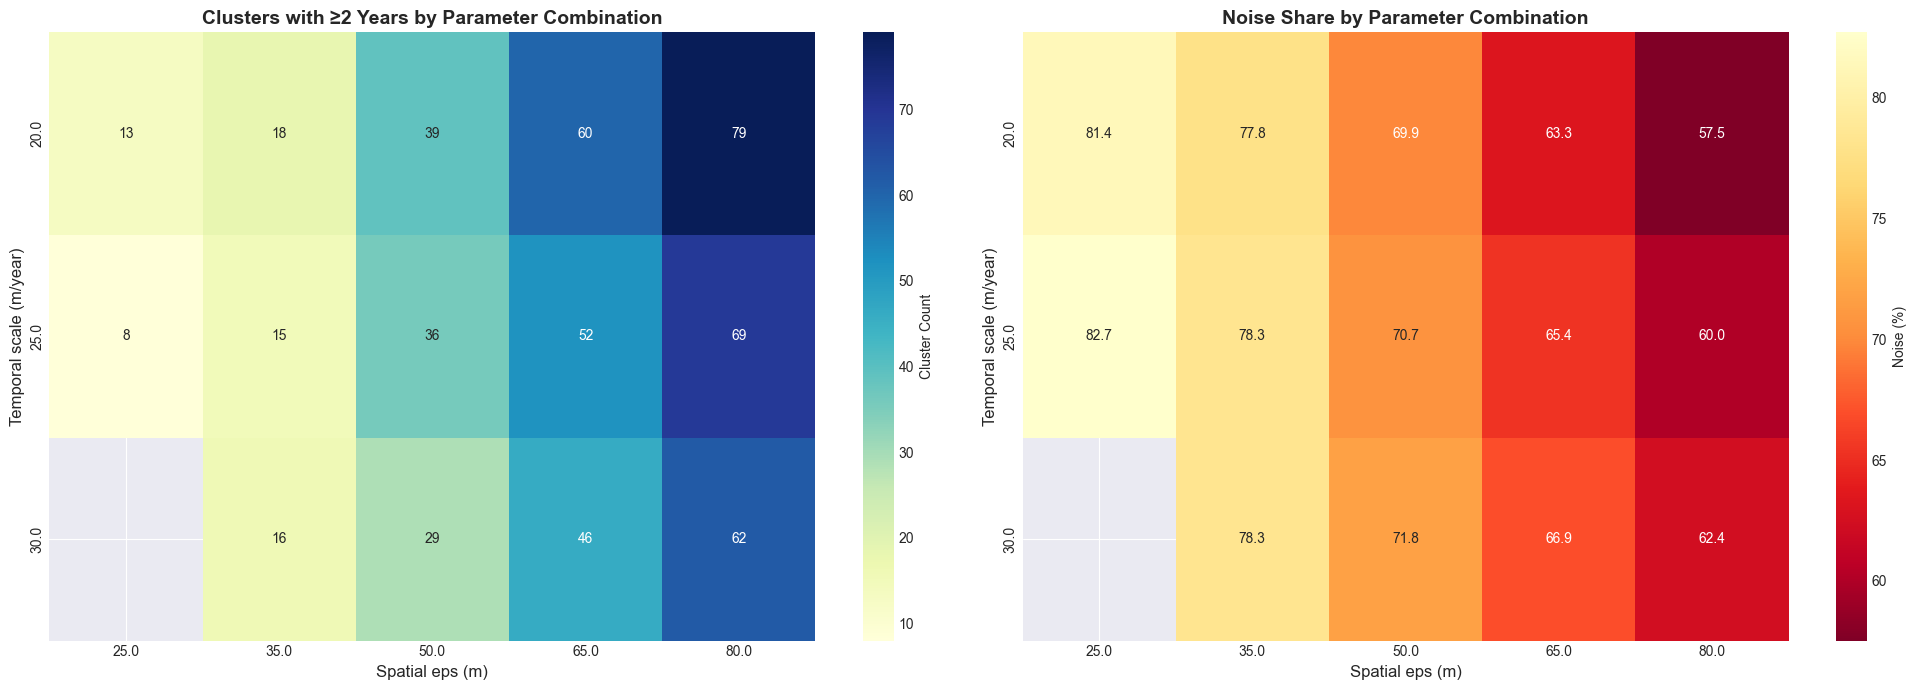

In [7]:
if not CONFIG.get('plots_enabled', True):
    print('Plot generation disabled via CONFIG — skipping parameter diagnostics.')
elif 'param_results_df' not in globals() or param_results_df.empty:
    print('⚠️ Parameter grid results not available; rerun the tuning cell first.')
else:
    rounded_params = param_results_df.copy()
    rounded_params['eps_display'] = rounded_params['eps_m'].round(0)
    rounded_params['temporal_display'] = rounded_params['temporal_scale_m'].round(0)

    cluster_grid = rounded_params.pivot_table(
        index='temporal_display',
        columns='eps_display',
        values='cluster_count',
        aggfunc='max'
    )

    noise_grid = rounded_params.pivot_table(
        index='temporal_display',
        columns='eps_display',
        values='noise_pct',
        aggfunc='mean'
    )

    if cluster_grid.empty or noise_grid.empty:
        print('⚠️ Parameter grid lacks enough combinations for diagnostics. Skipping heatmaps.')
    else:
        cluster_has_values = np.isfinite(cluster_grid.to_numpy(dtype=float)).any()
        noise_has_values = np.isfinite(noise_grid.to_numpy(dtype=float)).any()

        if not cluster_has_values or not noise_has_values:
            print('⚠️ Parameter grid lacked numeric values for heatmaps. Skipping diagnostics.')
        else:
            cluster_grid_plot = cluster_grid.sort_index().sort_index(axis=1)
            noise_grid_plot = noise_grid.reindex(index=cluster_grid_plot.index, columns=cluster_grid_plot.columns)

            if not np.isfinite(noise_grid_plot.to_numpy(dtype=float)).any():
                print('⚠️ Noise grid lacked numeric values after alignment. Skipping diagnostics.')
            else:
                fig, axes = plt.subplots(1, 2, figsize=(20, 7))

                sns.heatmap(
                    cluster_grid_plot, ax=axes[0], annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Cluster Count'}
                )
                axes[0].set_title('Clusters with ≥2 Years by Parameter Combination', fontsize=14, fontweight='bold')
                axes[0].set_xlabel('Spatial eps (m)', fontsize=12)
                axes[0].set_ylabel('Temporal scale (m/year)', fontsize=12)

                sns.heatmap(
                    noise_grid_plot, ax=axes[1], annot=True, fmt='.1f', cmap='YlOrRd_r', cbar_kws={'label': 'Noise (%)'}
                )
                axes[1].set_title('Noise Share by Parameter Combination', fontsize=14, fontweight='bold')
                axes[1].set_xlabel('Spatial eps (m)', fontsize=12)
                axes[1].set_ylabel('Temporal scale (m/year)', fontsize=12)

                plt.tight_layout()
                output_path = Path('../visualizations/clusters/parameter_scan_heatmaps.png')
                output_path.parent.mkdir(parents=True, exist_ok=True)
                plt.savefig(output_path, dpi=300, bbox_inches='tight')
                print(f'✓ Saved parameter diagnostics to: {output_path}')
                plt.show()

### 3c. Precision vs. Cluster Count Sweep
This optional sweep replays the top parameter candidates to compute coverage, radii, and spread velocities in feet. It surfaces parameter sets that keep spatial footprints near biological limits while still delivering enough clusters to train downstream models.

In [8]:
from math import isnan
FT_PER_M = 3.28084
def evaluate_parameter_tradeoff(results_df: pd.DataFrame, top_n: int = 15) -> pd.DataFrame:
    """Balance cluster coverage against spatial precision using top parameter candidates."""
    if results_df is None or results_df.empty:
        raise ValueError('Parameter scan results not available — rerun the tuning cell first.')
    candidates = (
        results_df.sort_values(['cluster_count', 'score'], ascending=[False, False])
        .head(top_n)
        .copy()
    )
    evaluations: List[Dict[str, object]] = []
    total_points = len(df_confirmed)
    for _, params in candidates.iterrows():
        eps_m = float(params['eps_m'])
        temporal_scale_m = float(params['temporal_scale_m'])
        min_samples = int(params['min_samples'])
        min_unique_years = int(params['min_unique_years'])
        labeled, raw_clusters, _ = run_dbscan_once(
            df_confirmed,
            eps_m=eps_m,
            temporal_scale_m=temporal_scale_m,
            min_samples=min_samples,
            min_unique_years=min_unique_years
        )
        if not raw_clusters:
            continue
        accepted_labels = [cluster['raw_label'] for cluster in raw_clusters]
        subset = labeled[labeled['cluster_raw_label'].isin(accepted_labels)].copy()
        coverage_pct = (len(subset) / total_points * 100) if total_points else 0.0
        cluster_metrics: List[Dict[str, float]] = []
        for label in accepted_labels:
            cluster_points = subset[subset['cluster_raw_label'] == label]
            centroid_x = float(cluster_points['x_m'].mean())
            centroid_y = float(cluster_points['y_m'].mean())
            radius_m = float(np.sqrt((cluster_points['x_m'] - centroid_x) ** 2 + (cluster_points['y_m'] - centroid_y) ** 2).max())
            year_span = int(cluster_points['INSPECTION_YEAR'].max() - cluster_points['INSPECTION_YEAR'].min())
            spread_ft_per_year = (radius_m * FT_PER_M / year_span) if year_span > 0 else np.nan
            cluster_metrics.append({
                'radius_ft': radius_m * FT_PER_M,
                'spread_ft_per_year': spread_ft_per_year,
                'year_span': year_span,
                'point_count': len(cluster_points)
            })
        cluster_metrics_df = pd.DataFrame(cluster_metrics)
        median_radius_ft = float(cluster_metrics_df['radius_ft'].median())
        pct_radius_le_75 = float((cluster_metrics_df['radius_ft'] <= 75).mean() * 100)
        spread_valid = cluster_metrics_df['spread_ft_per_year'].dropna()
        median_spread_ft_per_year = float(spread_valid.median()) if not spread_valid.empty else float('nan')
        pct_spread_le_100 = float((spread_valid <= 100).mean() * 100) if not spread_valid.empty else float('nan')
        precision_penalty = median_radius_ft / 75.0
        if not isnan(median_spread_ft_per_year):
            precision_penalty += median_spread_ft_per_year / 75.0
        balance_score = (params['cluster_count'] * coverage_pct) / (1.0 + precision_penalty)
        evaluations.append({
            'eps_m': eps_m,
            'temporal_scale_m': temporal_scale_m,
            'min_samples': min_samples,
            'min_unique_years': min_unique_years,
            'cluster_count': int(params['cluster_count']),
            'coverage_pct': coverage_pct,
            'median_radius_ft': median_radius_ft,
            'pct_radius_le_75': pct_radius_le_75,
            'median_spread_ft_per_year': median_spread_ft_per_year,
            'pct_spread_le_100': pct_spread_le_100,
            'balance_score': balance_score
        })
    if not evaluations:
        return pd.DataFrame()
    return pd.DataFrame(evaluations).sort_values('balance_score', ascending=False).reset_index(drop=True)

In [9]:
if 'param_results_df' not in globals() or param_results_df.empty:
    print('⚠️ Parameter scan results missing — rerun the tuning sweep above.')
else:
    tradeoff_results = evaluate_parameter_tradeoff(param_results_df, top_n=15)
    if tradeoff_results.empty:
        print('⚠️ No clusters met the precision filters during tradeoff replay.')
    else:
        cols_to_show = [
            'eps_m',
            'temporal_scale_m',
            'min_samples',
            'cluster_count',
            'coverage_pct',
            'median_radius_ft',
            'pct_radius_le_75',
            'median_spread_ft_per_year',
            'pct_spread_le_100',
            'balance_score'
        ]
        display(tradeoff_results[cols_to_show].head(CONFIG['diagnostics_preview_rows']))
        print('\nTop 5 candidates ranked by balance_score — higher means better coverage with tight spread.')
        print('Consider selecting a row that maintains ≥70% of cases in clusters while keeping median radius ≈75 ft or lower.')

,eps_m,temporal_scale_m,min_samples,cluster_count,coverage_pct,median_radius_ft,pct_radius_le_75,median_spread_ft_per_year,pct_spread_le_100,balance_score
0,80.0,20.0,3,79,37.081340,153.494736,16.455696,52.468272,75.949367,781.978167
1,80.0,25.0,3,69,33.911483,154.146220,14.492754,72.732066,66.666667,581.333386
2,65.0,20.0,3,60,29.306220,111.029705,21.666667,57.496040,75.000000,541.536133
3,80.0,30.0,3,62,31.100478,153.166937,12.903226,86.463823,54.838710,459.641089
4,65.0,25.0,3,52,26.614833,113.159299,23.076923,79.262605,61.538462,388.142651



Top 5 candidates ranked by balance_score — higher means better coverage with tight spread.
Consider selecting a row that maintains ≥70% of cases in clusters while keeping median radius ≈75 ft or lower.


## 4. Build Final Multi-Year Clusters

### 4a. Execute DBSCAN with Selected Parameters

In [10]:
effective_min_unique_years = int(CURRENT_RUN.get('min_unique_years_effective', MIN_UNIQUE_YEARS))
effective_min_samples = int(CURRENT_RUN.get('min_samples_effective', MIN_SAMPLES))

if CURRENT_RUN.get('best_params') is None:
    print('⚠️ No qualifying parameter combination produced clusters. Skipping final DBSCAN execution.')
    final_eps_m = float('nan')
    final_temporal_scale_m = float('nan')
    final_min_unique_years = effective_min_unique_years
    final_min_samples = effective_min_samples
    labeled_final = df_confirmed.copy()
    labeled_final['cluster_raw_label'] = -1
    clusters_raw = []
    final_metrics = {}
    df_clustered = pd.DataFrame()
else:
    best_params = CURRENT_RUN['best_params']
    final_eps_m = float(best_params['eps_m'])
    final_temporal_scale_m = float(best_params['temporal_scale_m'])
    final_min_unique_years = int(best_params.get('min_unique_years', effective_min_unique_years))
    final_min_samples = int(best_params.get('min_samples', effective_min_samples))

    labeled_final, clusters_raw, final_metrics = run_dbscan_once(
        df_confirmed,
        eps_m=final_eps_m,
        temporal_scale_m=final_temporal_scale_m,
        min_samples=final_min_samples,
        min_unique_years=final_min_unique_years
    )

    if not clusters_raw:
        print('⚠️ Best-parameter configuration did not yield any qualifying clusters after filtering.')
        df_clustered = pd.DataFrame()
    else:
        accepted_labels = [cluster['raw_label'] for cluster in clusters_raw]
        label_map = {raw_label: idx for idx, raw_label in enumerate(accepted_labels, start=1)}

        df_clustered = labeled_final[labeled_final['cluster_raw_label'].isin(accepted_labels)].copy()
        df_clustered['cluster_id'] = df_clustered['cluster_raw_label'].map(label_map)
        df_clustered = df_clustered.sort_values(['cluster_id', 'INSPECTION_YEAR']).reset_index(drop=True)

        noise_points_final = int((labeled_final['cluster_raw_label'] == -1).sum())

        print('✓ Final clustering complete with automatic parameter selection')
        if CURRENT_RUN.get('fallback_used'):
            print('  (Fallback thresholds were applied during parameter search)')
        print(f"  Clusters retained: {len(accepted_labels)}")
        print(f"  Points assigned to clusters: {len(df_clustered):,} ({len(df_clustered)/len(df_confirmed)*100:.1f}% of confirmed cases)")
        print(f"  Noise / discarded points: {noise_points_final:,}")
        print(f"  Minimum unique years enforced: {final_min_unique_years}")
        print(f"  Minimum samples enforced: {final_min_samples}")

if df_clustered.empty and CURRENT_RUN.get('best_params') is not None and clusters_raw:
    print('⚠️ Post-filtering left no clusters to retain; downstream tables will be empty.')

CURRENT_RUN['df_clustered'] = df_clustered
CURRENT_RUN['labeled_final'] = locals().get('labeled_final')
CURRENT_RUN['clusters_raw'] = clusters_raw if 'clusters_raw' in locals() else []

✓ Final clustering complete with automatic parameter selection
  Clusters retained: 79
  Points assigned to clusters: 620 (37.1% of confirmed cases)
  Noise / discarded points: 962
  Minimum unique years enforced: 2
  Minimum samples enforced: 3


## 5. Derive Cluster Features for Modeling

In [11]:
inv_transformer = Transformer.from_crs('EPSG:3857', 'EPSG:4326', always_xy=True)

def calculate_distance_m(x1: float, y1: float, x2: float, y2: float) -> float:
    return float(np.hypot(x2 - x1, y2 - y1))

effective_min_samples_for_features = int(globals().get('final_min_samples', CURRENT_RUN.get('min_samples_effective', MIN_SAMPLES)))

cluster_feature_rows: List[Dict] = []
cluster_payload: List[Dict] = []

if df_clustered.empty:
    print('⚠️ No clustered records available — feature table will be empty. Adjust parameters above and rerun.')
else:
    for cluster_id, cluster_points in df_clustered.groupby('cluster_id'):
        centroid_x = float(cluster_points['x_m'].mean())
        centroid_y = float(cluster_points['y_m'].mean())
        centroid_lon, centroid_lat = inv_transformer.transform(centroid_x, centroid_y)

        distances_m = np.sqrt((cluster_points['x_m'] - centroid_x) ** 2 + (cluster_points['y_m'] - centroid_y) ** 2)
        distances_km = distances_m / 1000.0
        radius_km = float(distances_km.max())
        mean_distance_km = float(distances_km.mean())
        std_distance_km = float(distances_km.std()) if len(distances_km) > 1 else 0.0

        start_year = int(cluster_points['INSPECTION_YEAR'].min())
        end_year = int(cluster_points['INSPECTION_YEAR'].max())
        unique_years = int(cluster_points['INSPECTION_YEAR'].nunique())
        year_span = int(end_year - start_year)
        annual_counts = (
            cluster_points.groupby('INSPECTION_YEAR').size().sort_index().astype(int).to_dict()
        )

        spread_rate_km_per_year = radius_km / year_span if year_span > 0 else np.nan
        area_km2 = float(np.pi * (radius_km ** 2))
        density_per_km2 = float(len(cluster_points) / area_km2) if area_km2 > 0 else np.nan

        dominant_species = (
            cluster_points['SPECIES'].dropna().mode().iat[0]
            if 'SPECIES' in cluster_points.columns and not cluster_points['SPECIES'].dropna().empty
            else 'Unknown'
        )
        dominant_landowner = (
            cluster_points['LANDOWNER_TYPE'].dropna().mode().iat[0]
            if 'LANDOWNER_TYPE' in cluster_points.columns and not cluster_points['LANDOWNER_TYPE'].dropna().empty
            else 'Unknown'
        )

        cluster_feature_rows.append({
            'cluster_id': int(cluster_id),
            'original_label': int(cluster_points['cluster_raw_label'].iloc[0]),
            'point_count': int(len(cluster_points)),
            'unique_years': unique_years,
            'start_year': start_year,
            'end_year': end_year,
            'year_span': year_span,
            'annual_counts': json.dumps({int(k): int(v) for k, v in annual_counts.items()}),
            'centroid_lat': float(centroid_lat),
            'centroid_lon': float(centroid_lon),
            'radius_km': radius_km,
            'mean_distance_km': mean_distance_km,
            'std_distance_km': std_distance_km,
            'area_km2': area_km2,
            'point_density_per_km2': density_per_km2,
            'spread_rate_km_per_year': spread_rate_km_per_year,
            'dominant_species': dominant_species,
            'dominant_landowner': dominant_landowner,
            'eps_m': final_eps_m,
            'temporal_scale_m': final_temporal_scale_m,
            'min_samples': effective_min_samples_for_features,
            'min_unique_years': final_min_unique_years
        })

        cases_payload = []
        for _, row in cluster_points.iterrows():
            lon = float(row['LONGITUDE'])
            lat = float(row['LATITUDE'])
            cases_payload.append({
                'inspection_id': str(row['Inspection_ID (unique)']) if 'Inspection_ID (unique)' in row and pd.notna(row['Inspection_ID (unique)']) else None,
                'latitude': lat,
                'longitude': lon,
                'inspection_year': int(row['INSPECTION_YEAR']),
                'inspection_date': row['INSPECTION_DATE'].strftime('%Y-%m-%d') if pd.notna(row['INSPECTION_DATE']) else None,
                'species': str(row['SPECIES']) if 'SPECIES' in row and pd.notna(row['SPECIES']) else None,
                'landowner_type': str(row['LANDOWNER_TYPE']) if 'LANDOWNER_TYPE' in row and pd.notna(row['LANDOWNER_TYPE']) else None
            })

        cluster_payload.append({
            'cluster_id': int(cluster_id),
            'point_count': int(len(cluster_points)),
            'unique_years': unique_years,
            'start_year': start_year,
            'end_year': end_year,
            'radius_km': radius_km,
            'centroid': {'lat': float(centroid_lat), 'lon': float(centroid_lon)},
            'annual_counts': annual_counts,
            'spread_rate_km_per_year': spread_rate_km_per_year,
            'dominant_species': dominant_species,
            'dominant_landowner': dominant_landowner,
            'cases': cases_payload
        })

cluster_features_df = pd.DataFrame(cluster_feature_rows).sort_values('cluster_id').reset_index(drop=True) if cluster_feature_rows else pd.DataFrame([])

print('✓ Computed feature table for machine learning (one row per cluster)')
print(cluster_features_df.head(CONFIG['diagnostics_preview_rows']))
print(f"Total clusters captured: {len(cluster_features_df)}")

CURRENT_RUN['cluster_features_df'] = cluster_features_df
CURRENT_RUN['cluster_payload'] = cluster_payload

✓ Computed feature table for machine learning (one row per cluster)
   cluster_id  original_label  point_count  unique_years  start_year  \
0           1               0            3             2        1989   
1           2               3            3             2        1992   
2           3               4            6             5        1992   
3           4               6            4             4        1992   
4           5               7            3             2        1994   

   end_year  year_span                                      annual_counts  \
0      1990          1                             {"1989": 1, "1990": 2}   
1      1994          2                             {"1992": 1, "1994": 2}   
2      1999          7  {"1992": 1, "1993": 1, "1995": 2, "1997": 1, "...   
3      1999          7       {"1992": 1, "1994": 1, "1997": 1, "1999": 1}   
4      1995          1                             {"1994": 1, "1995": 2}   

   centroid_lat  centroid_lon  ...  

In [12]:
print('=' * 70)
print('CLUSTER FEATURE SUMMARY (FOR MODELING)')
print('=' * 70)

if cluster_features_df.empty:
    print('No qualifying clusters were found. Consider adjusting the DBSCAN grid or filters.')
else:
    size_stats = cluster_features_df['point_count'].describe()
    radius_stats = cluster_features_df['radius_km'].describe()
    spread_stats = cluster_features_df['spread_rate_km_per_year'].dropna().describe()

    print('\nCounts per cluster (inspection rows):')
    print(size_stats)

    print('\nRadius distribution (km):')
    print(radius_stats)

    if not spread_stats.empty:
        print('\nSpread rate distribution (km/year):')
        print(spread_stats)

    print('\nUnique years per cluster:')
    print(cluster_features_df['unique_years'].describe())

    print('\nSample of modeling features:')
    display_columns = [
        'cluster_id', 'point_count', 'unique_years', 'year_span',
        'radius_km', 'spread_rate_km_per_year', 'centroid_lat', 'centroid_lon'
    ]
    preview_limit = min(CONFIG['diagnostics_preview_rows'], len(cluster_features_df))
    print(cluster_features_df[display_columns].head(preview_limit))

CLUSTER FEATURE SUMMARY (FOR MODELING)

Counts per cluster (inspection rows):
count     79.000000
mean       7.848101
std       13.389710
min        3.000000
25%        3.000000
50%        4.000000
75%        6.500000
max      110.000000
Name: point_count, dtype: float64

Radius distribution (km):
count    79.000000
mean      0.053813
std       0.034921
min       0.000000
25%       0.031261
50%       0.046785
75%       0.074280
max       0.181818
Name: radius_km, dtype: float64

Spread rate distribution (km/year):
count    79.000000
mean      0.022368
std       0.019120
min       0.000000
25%       0.010157
50%       0.015992
75%       0.028387
max       0.100673
Name: spread_rate_km_per_year, dtype: float64

Unique years per cluster:
count    79.000000
mean      3.050633
std       1.084846
min       2.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       6.000000
Name: unique_years, dtype: float64

Sample of modeling features:
   cluster_id  point_count  unique_yea

In [13]:
# Expert-facing spread benchmarks derived from current clustering outputs
if cluster_features_df.empty or df_clustered.empty:
    print('⚠️ No clusters to benchmark — rerun the parameter scan and final DBSCAN cells.')
else:
    km_to_ft = 3280.84
    total_clusters = int(len(cluster_features_df))
    clustered_cases = int(len(df_clustered))
    total_confirmed = int(len(df_confirmed))
    cases_share_pct = (clustered_cases / total_confirmed * 100) if total_confirmed else float('nan')
    radius_ft = cluster_features_df['radius_km'] * km_to_ft
    spread_ft_per_year = cluster_features_df['spread_rate_km_per_year'].dropna() * km_to_ft
    multi_year_mask = cluster_features_df['year_span'] > 0
    multi_year_clusters = int(multi_year_mask.sum())
    rows = [
        ('Total qualifying clusters', total_clusters, 'Meets CONFIG thresholds (min_samples & unique years)'),
        ('Cases assigned to clusters', f"{clustered_cases} of {total_confirmed} ({cases_share_pct:.1f}%)", 'Confirmed inspections contributing to clusters'),
        ('Median points per cluster', f"{cluster_features_df['point_count'].median():.0f}", 'Central density for validation vs. field observations'),
        ('Median radius (ft)', f"{radius_ft.median():.1f}", 'Half-width of activity footprint around centroid'),
        ('90th percentile radius (ft)', f"{radius_ft.quantile(0.9):.1f}", 'Flags spatial outliers for expert review'),
        ('Clusters ≤ 75 ft radius', f"{int((radius_ft <= 75).sum())} ({(radius_ft <= 75).mean() * 100:.1f}%)", 'Check against expected annual spread distance'),
        ('Median temporal span (years)', f"{cluster_features_df['year_span'].median():.1f}", 'Duration between first and last observation per cluster'),
        ('Clusters with multi-year data', f"{multi_year_clusters} ({(multi_year_clusters / total_clusters * 100 if total_clusters else 0):.1f}%)", 'Eligible for spread-rate validation'),
    ]
    if not spread_ft_per_year.empty:
        rows.extend([
            ('Median spread rate (ft/year)', f"{spread_ft_per_year.median():.1f}", 'Compare with expected ≤75 ft/year progression'),
            ('90th percentile spread rate (ft/year)', f"{spread_ft_per_year.quantile(0.9):.1f}", 'Identify fast-moving clusters requiring confirmation'),
            ('Share ≤ 100 ft/year', f"{(spread_ft_per_year <= 100).mean() * 100:.1f}%", 'Proportion within conservative biological bounds')
        ])
    else:
        rows.append(('Median spread rate (ft/year)', 'N/A', 'Insufficient multi-year clusters to compute velocity'))
    expert_summary = pd.DataFrame(rows, columns=['Metric', 'Value', 'Notes'])
    display(expert_summary)
    if not spread_ft_per_year.empty:
        print('\nAdditional spread checks (ft/year):')
        print(f"  • Maximum observed velocity: {spread_ft_per_year.max():.1f}")
        print(f"  • Clusters > 150 ft/year: {(spread_ft_per_year > 150).sum()} of {len(spread_ft_per_year)} multi-year clusters")
    print('\nAll radii and velocities are reported in feet (1 km = 3,280.84 ft); use these benchmarks for expert validation discussions.')

,Metric,Value,Notes
0,Total qualifying clusters,79,Meets CONFIG thresholds (min_samples & unique ...
1,Cases assigned to clusters,620 of 1672 (37.1%),Confirmed inspections contributing to clusters
2,Median points per cluster,4,Central density for validation vs. field obser...
3,Median radius (ft),153.5,Half-width of activity footprint around centroid
4,90th percentile radius (ft),335.1,Flags spatial outliers for expert review
5,Clusters ≤ 75 ft radius,13 (16.5%),Check against expected annual spread distance
6,Median temporal span (years),3.0,Duration between first and last observation pe...
7,Clusters with multi-year data,79 (100.0%),Eligible for spread-rate validation
8,Median spread rate (ft/year),52.5,Compare with expected ≤75 ft/year progression
9,90th percentile spread rate (ft/year),147.6,Identify fast-moving clusters requiring confir...



Additional spread checks (ft/year):
  • Maximum observed velocity: 330.3
  • Clusters > 150 ft/year: 8 of 79 multi-year clusters

All radii and velocities are reported in feet (1 km = 3,280.84 ft); use these benchmarks for expert validation discussions.


## 6. Visual Diagnostics

### 6a. Cluster Footprints and Temporal Spread

✓ Saved cluster diagnostic figure to: ../visualizations/clusters/multi_year_cluster_diagnostic.png


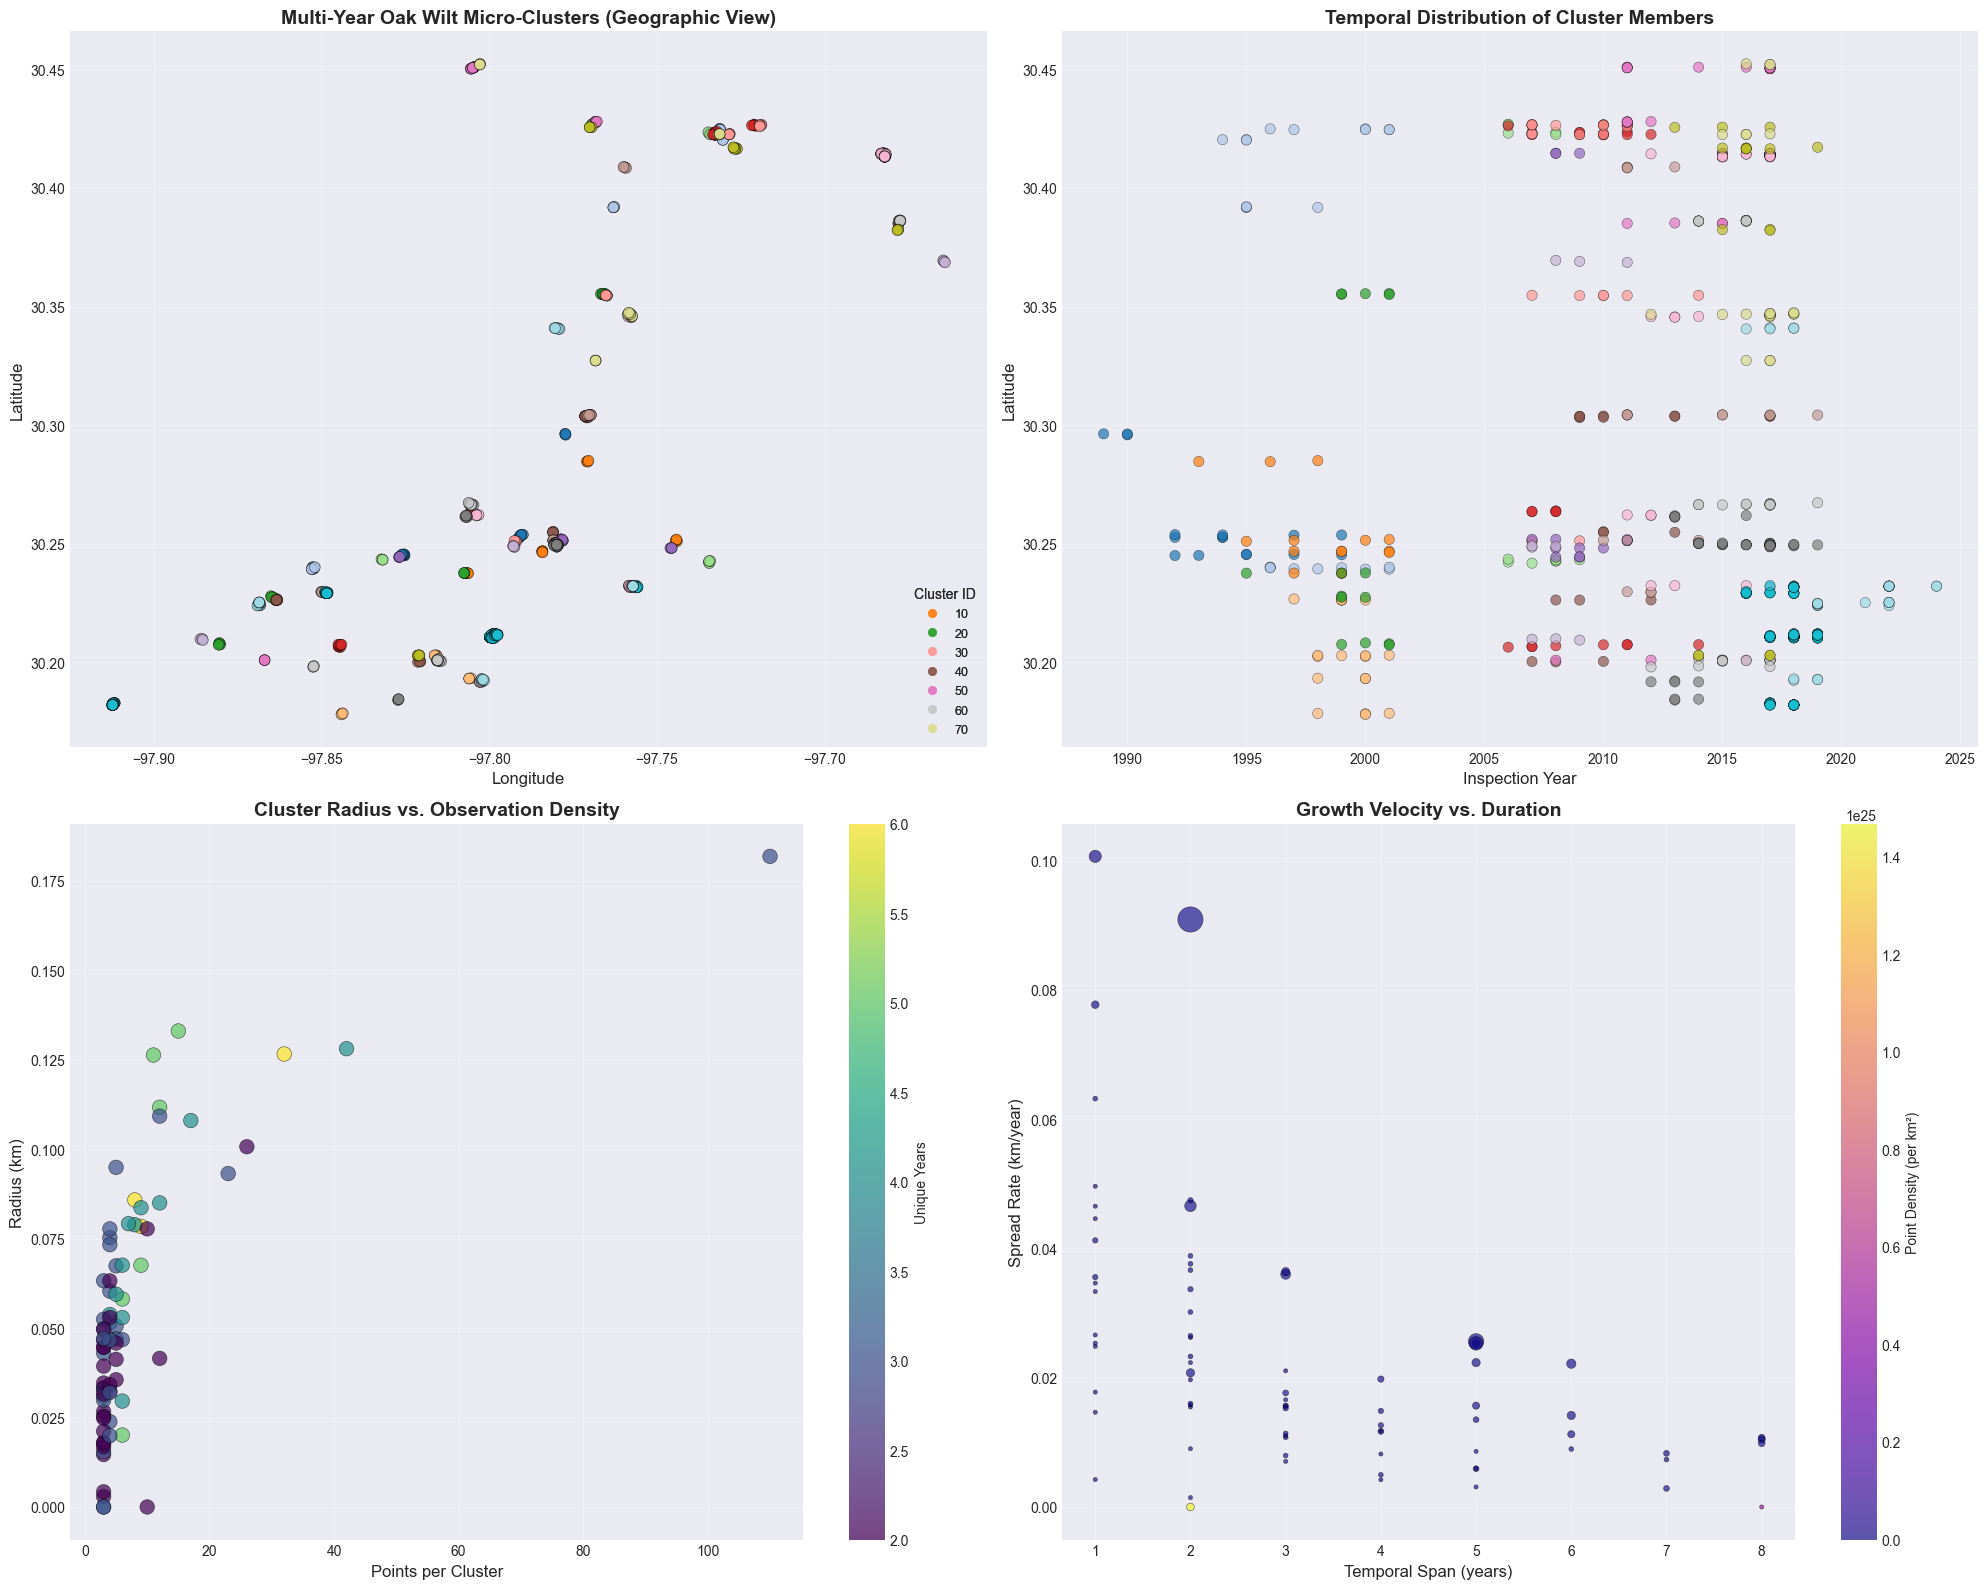

In [14]:
if not CONFIG.get('plots_enabled', True):
    print('Plot generation disabled via CONFIG — skipping multi-panel diagnostics.')
elif cluster_features_df.empty or df_clustered.empty:
    print('⚠️ No clusters available for visualization. Skipping plots.')
else:
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # Map view
    ax_map = axes[0, 0]
    scatter_map = ax_map.scatter(
        df_clustered['LONGITUDE'],
        df_clustered['LATITUDE'],
        c=df_clustered['cluster_id'],
        cmap='tab20',
        s=60,
        alpha=0.75,
        edgecolors='black',
        linewidth=0.4
    )
    ax_map.set_xlabel('Longitude', fontsize=12)
    ax_map.set_ylabel('Latitude', fontsize=12)
    ax_map.set_title('Multi-Year Oak Wilt Micro-Clusters (Geographic View)', fontsize=14, fontweight='bold')
    ax_map.grid(True, alpha=0.3)
    legend1 = ax_map.legend(*scatter_map.legend_elements(num=8), title='Cluster ID', fontsize=9, loc='lower right')
    ax_map.add_artist(legend1)

    # Temporal spread vs latitude
    ax_time = axes[0, 1]
    ax_time.scatter(
        df_clustered['INSPECTION_YEAR'],
        df_clustered['LATITUDE'],
        c=df_clustered['cluster_id'],
        cmap='tab20',
        s=55,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.3
    )
    ax_time.set_xlabel('Inspection Year', fontsize=12)
    ax_time.set_ylabel('Latitude', fontsize=12)
    ax_time.set_title('Temporal Distribution of Cluster Members', fontsize=14, fontweight='bold')
    ax_time.grid(True, alpha=0.3)

    # Cluster radius vs point count
    ax_radius = axes[1, 0]
    ax_radius.scatter(
        cluster_features_df['point_count'],
        cluster_features_df['radius_km'],
        s=110,
        alpha=0.7,
        edgecolors='black',
        c=cluster_features_df['unique_years'],
        cmap='viridis',
        linewidth=0.4
    )
    ax_radius.set_xlabel('Points per Cluster', fontsize=12)
    ax_radius.set_ylabel('Radius (km)', fontsize=12)
    ax_radius.set_title('Cluster Radius vs. Observation Density', fontsize=14, fontweight='bold')
    ax_radius.grid(True, alpha=0.3)
    cbar_radius = plt.colorbar(ax_radius.collections[0], ax=ax_radius)
    cbar_radius.set_label('Unique Years', fontsize=10)

    # Spread rate vs temporal span
    ax_spread = axes[1, 1]
    valid_spread = cluster_features_df[cluster_features_df['spread_rate_km_per_year'].notna()]
    if valid_spread.empty:
        ax_spread.text(0.5, 0.5, 'Spread-rate requires \nmultiple years of radius change',
                      ha='center', va='center', fontsize=14)
        ax_spread.set_xticks([])
        ax_spread.set_yticks([])
    else:
        ax_spread.scatter(
            valid_spread['year_span'],
            valid_spread['spread_rate_km_per_year'],
            s=valid_spread['point_count'] * 3,
            alpha=0.65,
            edgecolors='black',
            c=valid_spread['point_density_per_km2'],
            cmap='plasma',
            linewidth=0.4
        )
        ax_spread.set_xlabel('Temporal Span (years)', fontsize=12)
        ax_spread.set_ylabel('Spread Rate (km/year)', fontsize=12)
        ax_spread.set_title('Growth Velocity vs. Duration', fontsize=14, fontweight='bold')
        ax_spread.grid(True, alpha=0.3)
        cbar_spread = plt.colorbar(ax_spread.collections[0], ax=ax_spread)
        cbar_spread.set_label('Point Density (per km²)', fontsize=10)

    plt.tight_layout()
    output_path = Path('../visualizations/clusters/multi_year_cluster_diagnostic.png')
    output_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f'✓ Saved cluster diagnostic figure to: {output_path}')
    plt.show()

✓ Saved representative cluster footprints to: ../visualizations/clusters/sample_cluster_footprints.png


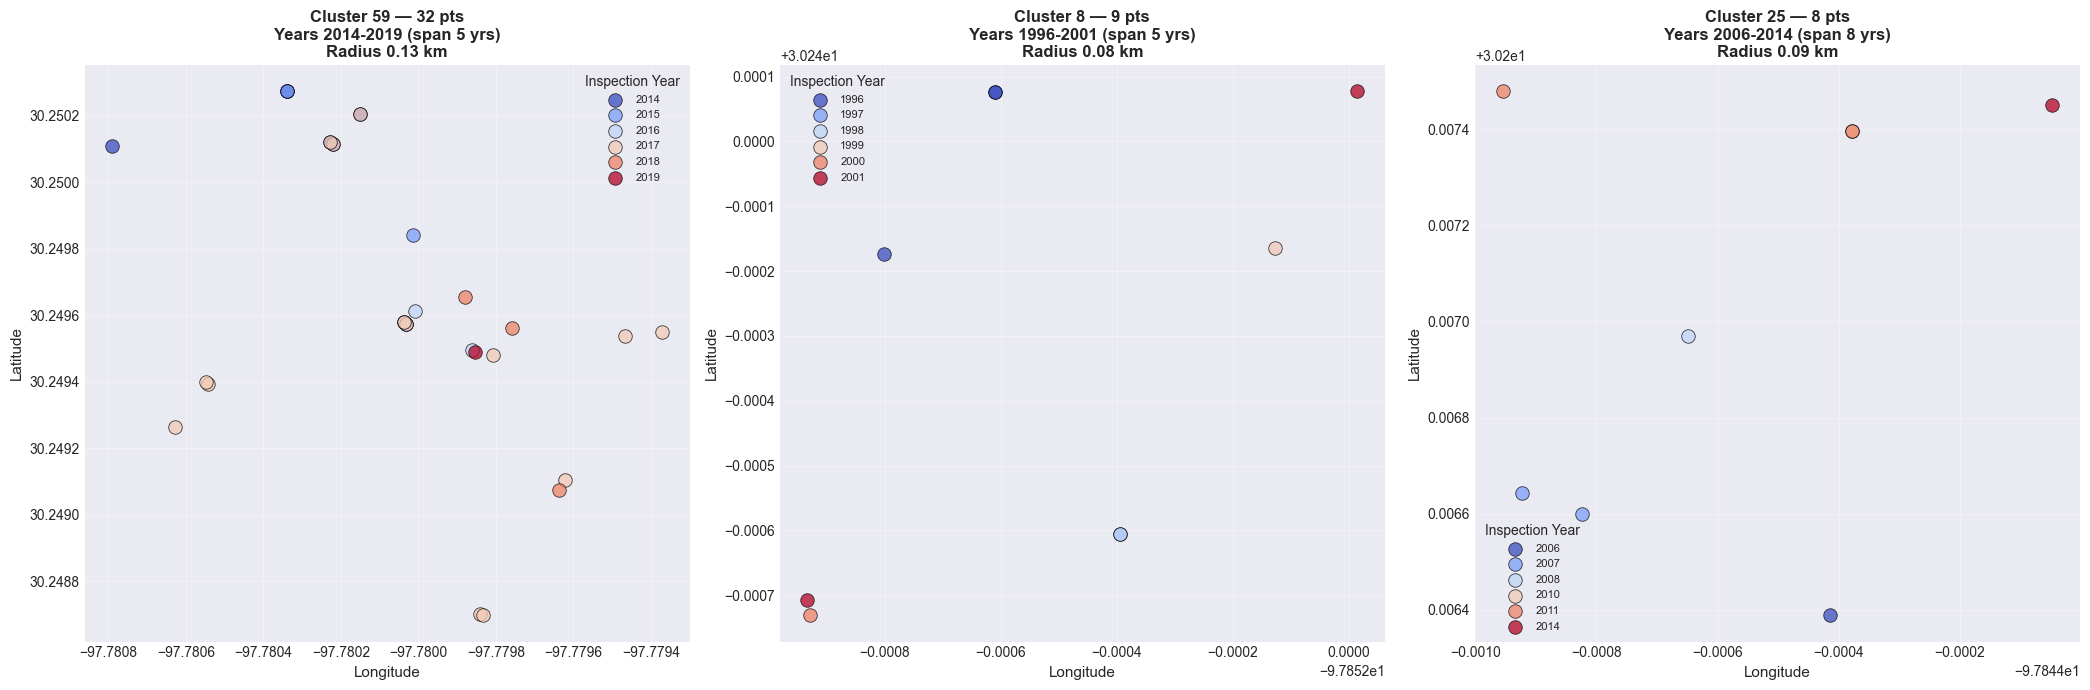

In [15]:
if not CONFIG.get('plots_enabled', True):
    print('Plot generation disabled via CONFIG — skipping per-cluster footprints.')
elif cluster_features_df.empty:
    print('⚠️ Skipping per-cluster footprints because no clusters are available.')
else:
    top_candidates = cluster_features_df.sort_values(['unique_years', 'point_count'], ascending=[False, False]).head(3)
    n_panels = len(top_candidates)
    fig, axes = plt.subplots(1, n_panels, figsize=(7 * n_panels, 7), squeeze=False)

    for ax, (_, cluster_row) in zip(axes[0], top_candidates.iterrows()):
        cid = cluster_row['cluster_id']
        subset = df_clustered[df_clustered['cluster_id'] == cid].sort_values('INSPECTION_YEAR')
        years = sorted(subset['INSPECTION_YEAR'].unique())
        year_colors = plt.cm.coolwarm(np.linspace(0, 1, len(years)))

        for color, year in zip(year_colors, years):
            year_data = subset[subset['INSPECTION_YEAR'] == year]
            ax.scatter(
                year_data['LONGITUDE'],
                year_data['LATITUDE'],
                c=[color],
                s=95,
                alpha=0.75,
                edgecolors='black',
                linewidth=0.6,
                label=str(int(year))
            )

        ax.set_title(
            f"Cluster {int(cid)} — {int(cluster_row['point_count'])} pts\n"
            f"Years {int(cluster_row['start_year'])}-{int(cluster_row['end_year'])} "
            f"(span {int(cluster_row['year_span'])} yrs)\n"
            f"Radius {cluster_row['radius_km']:.2f} km",
            fontsize=12,
            fontweight='bold'
        )
        ax.set_xlabel('Longitude', fontsize=11)
        ax.set_ylabel('Latitude', fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(title='Inspection Year', fontsize=8, loc='best')

    plt.tight_layout()
    output_path = Path('../visualizations/clusters/sample_cluster_footprints.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f'✓ Saved representative cluster footprints to: {output_path}')
    plt.show()

### 6c. Temporal Intensity Profiles

✓ Saved cluster activity timelines to: ../visualizations/clusters/cluster_activity_timelines.png


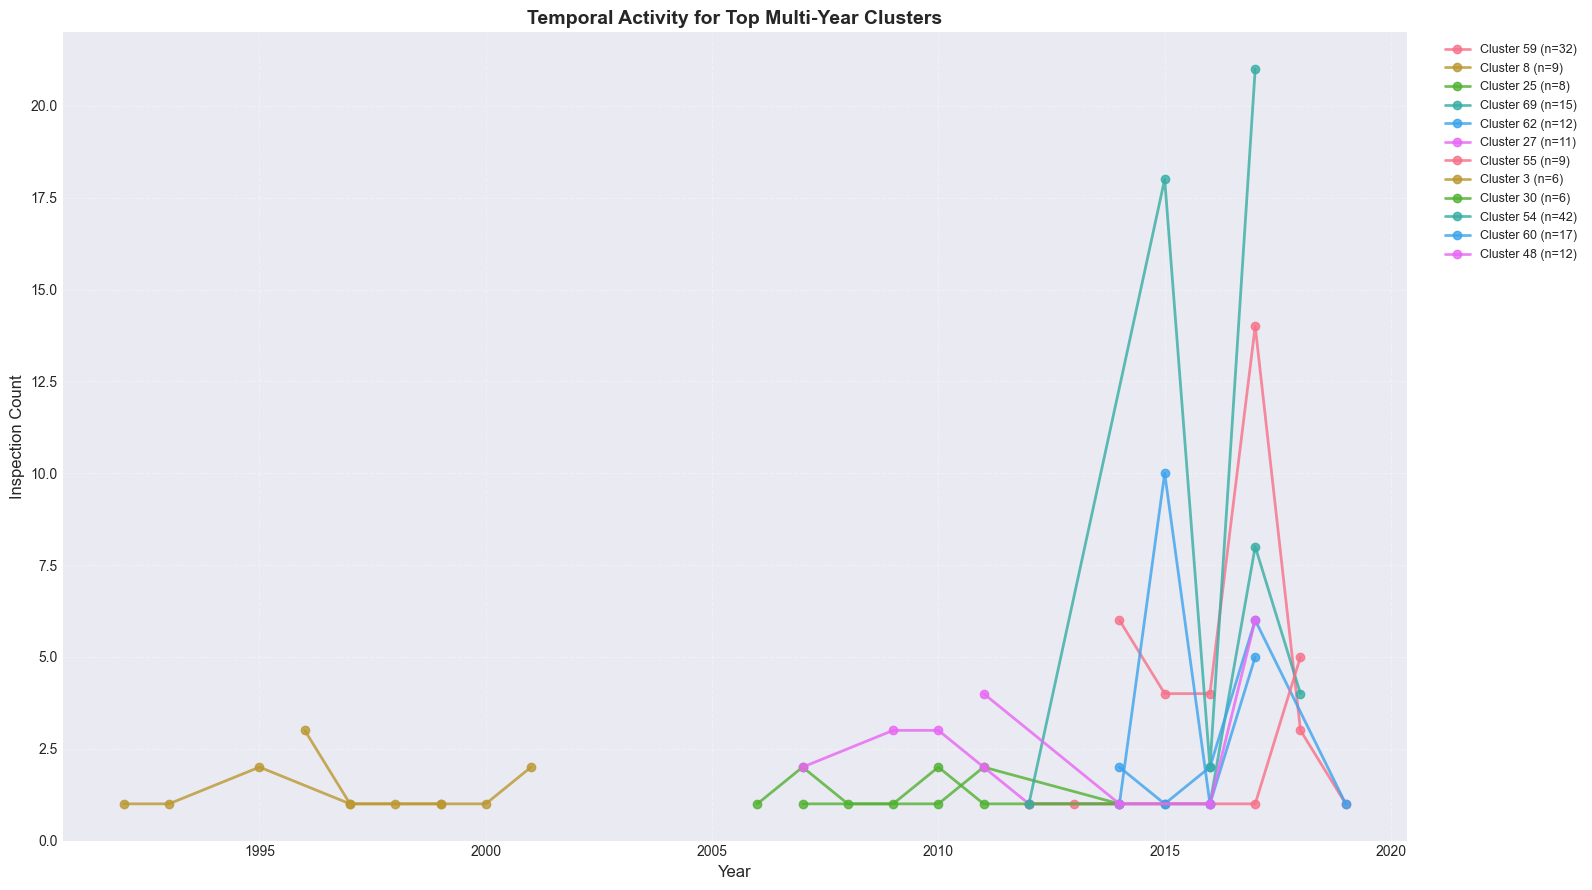

In [16]:
if not CONFIG.get('plots_enabled', True):
    print('Plot generation disabled via CONFIG — skipping timeline plot.')
elif cluster_features_df.empty:
    print('⚠️ Skipping timeline plot because no clusters were generated.')
else:
    candidate_order = cluster_features_df.sort_values(
        ['unique_years', 'point_count'], ascending=[False, False])
    top_ids = candidate_order['cluster_id'].head(12).tolist()

    fig, ax = plt.subplots(figsize=(16, 9))
    for cid in top_ids:
        subset = df_clustered[df_clustered['cluster_id'] == cid]
        yearly_counts = subset.groupby('INSPECTION_YEAR').size().sort_index()
        ax.plot(
            yearly_counts.index,
            yearly_counts.values,
            marker='o',
            linewidth=2,
            markersize=6,
            alpha=0.8,
            label=f'Cluster {cid} (n={int(subset.shape[0])})'
        )

    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Inspection Count', fontsize=12)
    ax.set_title('Temporal Activity for Top Multi-Year Clusters', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

    plt.tight_layout()
    output_path = Path('../visualizations/clusters/cluster_activity_timelines.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f'✓ Saved cluster activity timelines to: {output_path}')
    plt.show()

✓ Saved cluster distribution plots to: ../visualizations/clusters/cluster_size_radius_distributions.png


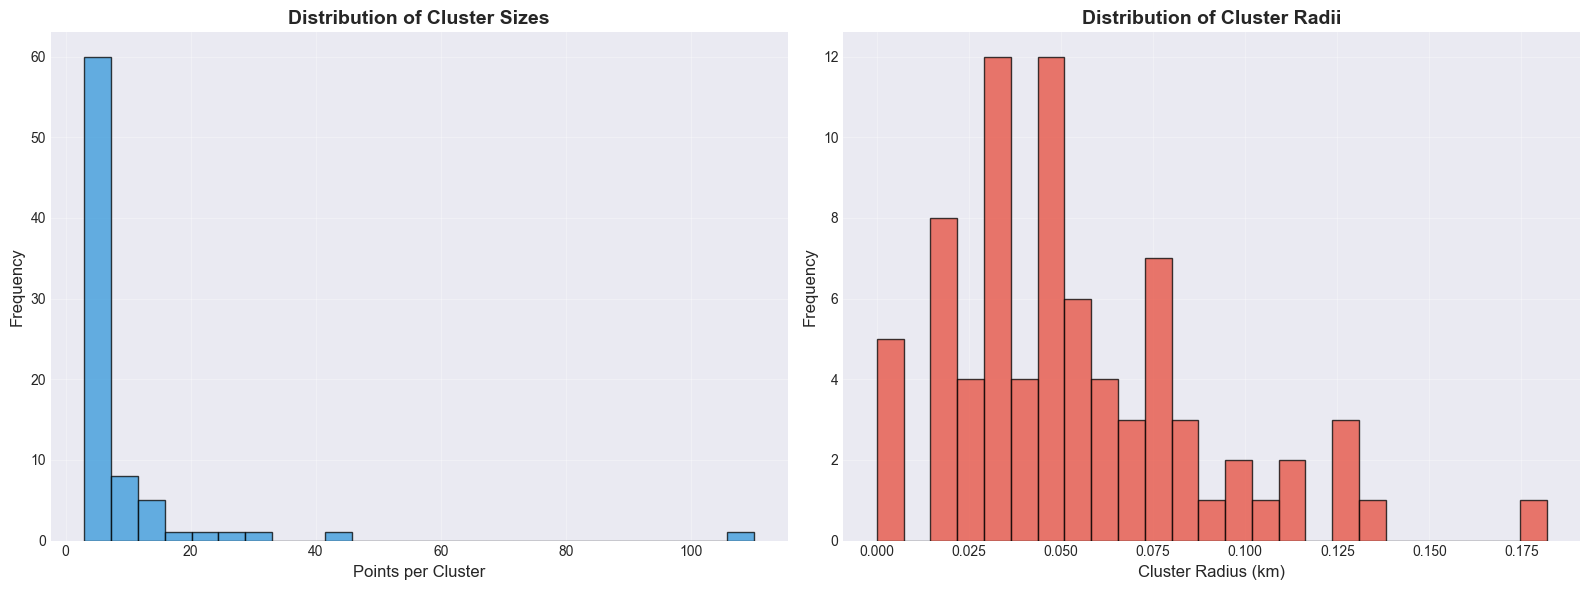

In [17]:
if not CONFIG.get('plots_enabled', True):
    print('Plot generation disabled via CONFIG — skipping distribution plots.')
elif cluster_features_df.empty:
    print('⚠️ No clusters available for distribution plots.')
else:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].hist(cluster_features_df['point_count'], bins=25, color='#3498db', edgecolor='black', alpha=0.75)
    axes[0].set_xlabel('Points per Cluster', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Distribution of Cluster Sizes', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    axes[1].hist(cluster_features_df['radius_km'], bins=25, color='#e74c3c', edgecolor='black', alpha=0.75)
    axes[1].set_xlabel('Cluster Radius (km)', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Distribution of Cluster Radii', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    output_path = Path('../visualizations/clusters/cluster_size_radius_distributions.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f'✓ Saved cluster distribution plots to: {output_path}')
    plt.show()

## 7. Export Datasets for Modeling Pipelines

In [18]:
export_dir = Path('../data')
export_dir.mkdir(parents=True, exist_ok=True)

feature_csv_path = export_dir / 'oak_wilt_cluster_features.csv'
member_csv_path = export_dir / 'oak_wilt_cluster_members.csv'
parameter_scan_path = export_dir / 'oak_wilt_cluster_parameter_scan.csv'
json_output_path = export_dir / 'oak_wilt_cluster_cases.json'

effective_min_samples_for_export = int(globals().get('final_min_samples', CURRENT_RUN.get('min_samples_effective', MIN_SAMPLES)))
member_export_df = pd.DataFrame()

if not CONFIG.get('exports_enabled', True):
    print('Exports disabled via CONFIG — skipping file generation.')
elif cluster_features_df.empty:
    print('⚠️ No clusters to export. Files were not generated.')
else:
    cluster_features_df.to_csv(feature_csv_path, index=False)

    member_columns = [
        'cluster_id', 'cluster_raw_label', 'LATITUDE', 'LONGITUDE',
        'INSPECTION_YEAR', 'INSPECTION_DATE', 'SPECIES', 'LANDOWNER_TYPE'
    ]
    available_member_columns = [col for col in member_columns if col in df_clustered.columns]

    member_export_df = df_clustered[available_member_columns].copy()
    member_export_df.rename(columns={'cluster_raw_label': 'original_label'}, inplace=True)
    member_export_df.to_csv(member_csv_path, index=False)

    param_results_df.to_csv(parameter_scan_path, index=False)

    # Assemble JSON payload
    export_payload = {
        'metadata': {
            'generated_at': datetime.now().isoformat(),
            'source_file': str(data_path),
            'total_confirmed_cases': int(len(df_confirmed)),
            'clustered_cases': int(len(df_clustered)),
            'cluster_count': int(len(cluster_features_df))
        },
        'parameters': {
            'selected_eps_m': final_eps_m,
            'selected_temporal_scale_m': final_temporal_scale_m,
            'min_samples': effective_min_samples_for_export,
            'min_unique_years': final_min_unique_years
        },
        'cluster_features_columns': cluster_features_df.columns.tolist(),
        'clusters': cluster_payload
    }

    with open(json_output_path, 'w') as f:
        json.dump(export_payload, f, indent=2)

    print('✓ Exported modeling datasets:')
    print(f'  • {feature_csv_path.name} (cluster-level features)')
    print(f'  • {member_csv_path.name} (case-level members)')
    print(f'  • {parameter_scan_path.name} (parameter scan results)')
    print(f'  • {json_output_path.name} (hierarchical JSON payload)')

CURRENT_RUN['member_export_df'] = member_export_df

✓ Exported modeling datasets:
  • oak_wilt_cluster_features.csv (cluster-level features)
  • oak_wilt_cluster_members.csv (case-level members)
  • oak_wilt_cluster_parameter_scan.csv (parameter scan results)
  • oak_wilt_cluster_cases.json (hierarchical JSON payload)


In [19]:
if cluster_features_df.empty:
    print('No export previews available because no clusters were generated.')
else:
    print('Cluster feature preview:')
    preview_cols = ['cluster_id', 'point_count', 'unique_years', 'radius_km', 'spread_rate_km_per_year', 'centroid_lat', 'centroid_lon']
    print(cluster_features_df[preview_cols].head(min(CONFIG['diagnostics_preview_rows'], len(cluster_features_df))))

    member_export_preview = CURRENT_RUN.get('member_export_df', pd.DataFrame())
    if CONFIG.get('exports_enabled', True) and not member_export_preview.empty:
        print('\nMember sample (first rows):')
        member_preview_cols = ['cluster_id', 'original_label', 'LATITUDE', 'LONGITUDE', 'INSPECTION_YEAR', 'SPECIES']
        print(member_export_preview[member_preview_cols[:len(member_export_preview.columns)]].head(min(CONFIG['diagnostics_preview_rows'], len(member_export_preview))))
    else:
        print('\nMember-level preview skipped (exports disabled or no member_export_df).')

Cluster feature preview:
   cluster_id  point_count  unique_years  radius_km  spread_rate_km_per_year  \
0           1            3             2   0.033330                 0.033330   
1           2            3             2   0.002900                 0.001450   
2           3            6             5   0.058130                 0.008304   
3           4            4             4   0.051373                 0.007339   
4           5            3             2   0.014653                 0.014653   

   centroid_lat  centroid_lon  
0     30.296167    -97.777288  
1     30.252686    -97.791044  
2     30.245315    -97.825583  
3     30.253692    -97.790357  
4     30.420323    -97.730320  

Member sample (first rows):
   cluster_id  original_label   LATITUDE  LONGITUDE  INSPECTION_YEAR  \
0           1               0  30.296323 -97.777386             1989   
1           1               0  30.295916 -97.777216             1990   
2           1               0  30.296262 -97.777261      

## 8. Summary & Next Steps

In [20]:
print('=' * 80)
print('OAK WILT CLUSTERING SUMMARY')
print('=' * 80)

effective_min_samples = int(globals().get('final_min_samples', CURRENT_RUN.get('min_samples_effective', MIN_SAMPLES)))
effective_min_unique_years = int(globals().get('final_min_unique_years', CURRENT_RUN.get('min_unique_years_effective', MIN_UNIQUE_YEARS)))
final_eps_value = globals().get('final_eps_m', float('nan'))
final_temporal_value = globals().get('final_temporal_scale_m', float('nan'))
eps_display = f"{final_eps_value:.1f} m" if np.isfinite(final_eps_value) else 'N/A'
temporal_display = f"{final_temporal_value:.1f} m/year" if np.isfinite(final_temporal_value) else 'N/A'

print(f"Confirmed cases analysed: {len(df_confirmed):,}")
print(f"Cases assigned to clusters: {len(df_clustered):,} ({(len(df_clustered)/len(df_confirmed)*100 if len(df_confirmed) else 0):.1f}%)")
print(f"Total clusters (≥{effective_min_unique_years} years & ≥{effective_min_samples} points): {len(cluster_features_df)}")
print(f"Parameter selection -> eps: {eps_display}, temporal_scale: {temporal_display}")
print(f"Minimum unique years enforced in final clusters: {effective_min_unique_years}")
print(f"Minimum samples enforced in final clusters: {effective_min_samples}")
if CURRENT_RUN.get('fallback_used'):
    print('  (Fallback thresholds were required to obtain clusters)')

if CURRENT_RUN.get('best_params') is None or cluster_features_df.empty:
    print('\nNo qualifying clusters were produced; consider expanding the parameter grid, relaxing thresholds informed by the density diagnostics, or enriching the dataset.')
else:
    print('\nKey Distributions:')
    print(f"  • Median points per cluster: {cluster_features_df['point_count'].median():.0f}")
    print(f"  • Median radius: {cluster_features_df['radius_km'].median():.2f} km")
    print(f"  • Median unique years: {cluster_features_df['unique_years'].median():.0f}")

    valid_spread = cluster_features_df['spread_rate_km_per_year'].dropna()
    if not valid_spread.empty:
        print(f"  • Median spread rate: {valid_spread.median():.2f} km/year")

    print('\nRecommended follow-up:')
    print('  1. Feed oak_wilt_cluster_features.csv into ML pipelines for radius prediction.')
    print('  2. Use oak_wilt_cluster_members.csv to reconstruct spatial footprints for feature augmentation.')
    print('  3. Inspect parameter scan CSV to understand sensitivity to eps/temporal scaling.')

OAK WILT CLUSTERING SUMMARY
Confirmed cases analysed: 1,672
Cases assigned to clusters: 620 (37.1%)
Total clusters (≥2 years & ≥3 points): 79
Parameter selection -> eps: 80.0 m, temporal_scale: 20.0 m/year
Minimum unique years enforced in final clusters: 2
Minimum samples enforced in final clusters: 3

Key Distributions:
  • Median points per cluster: 4
  • Median radius: 0.05 km
  • Median unique years: 3
  • Median spread rate: 0.02 km/year

Recommended follow-up:
  1. Feed oak_wilt_cluster_features.csv into ML pipelines for radius prediction.
  2. Use oak_wilt_cluster_members.csv to reconstruct spatial footprints for feature augmentation.
  3. Inspect parameter scan CSV to understand sensitivity to eps/temporal scaling.


## 9. Notes for Modeling Teams

In [21]:
if cluster_features_df.empty:
    print('No clusters available yet. Rerun earlier steps after adjusting parameters.')
else:
    print('\nKey Artifacts:')
    print(f"  • Cluster features CSV: {feature_csv_path}") if CONFIG.get('exports_enabled', True) else print('  • Exports disabled in CONFIG')
    if CONFIG.get('exports_enabled', True):
        print(f"  • Member-level CSV: {member_csv_path}")
        print(f"  • Parameter scan CSV: {parameter_scan_path}")
        print(f"  • JSON bundle: {json_output_path}")
    
    print('\nSuggested Modeling Features:')
    print('  - radius_km, mean_distance_km, point_density_per_km2')
    print('  - year_span, unique_years, spread_rate_km_per_year')
    print('  - centroid_lat/centroid_lon for spatial anchoring (consider encoding)')
    print('  - dominant_species, dominant_landowner for categorical signals')

    print('\nValidation Ideas:')
    print('  1. Compare predicted radii with observed radii_km using temporal cross-validation.')
    print('  2. Stress-test model on clusters with wide year_span to capture long-term spread.')
    print('  3. Integrate external covariates (soil, canopy) anchored by centroid coordinates.')


Key Artifacts:
  • Cluster features CSV: ../data/oak_wilt_cluster_features.csv
  • Member-level CSV: ../data/oak_wilt_cluster_members.csv
  • Parameter scan CSV: ../data/oak_wilt_cluster_parameter_scan.csv
  • JSON bundle: ../data/oak_wilt_cluster_cases.json

Suggested Modeling Features:
  - radius_km, mean_distance_km, point_density_per_km2
  - year_span, unique_years, spread_rate_km_per_year
  - centroid_lat/centroid_lon for spatial anchoring (consider encoding)
  - dominant_species, dominant_landowner for categorical signals

Validation Ideas:
  1. Compare predicted radii with observed radii_km using temporal cross-validation.
  2. Stress-test model on clusters with wide year_span to capture long-term spread.
  3. Integrate external covariates (soil, canopy) anchored by centroid coordinates.


In [22]:
import json
from pathlib import Path
from datetime import datetime

bundle = json.load(open('../data/oak_wilt_cluster_cases.json'))
clusters_out = []
for cluster in bundle['clusters']:
    stats = {
        "total_cases": cluster['point_count'],
        "geographic_center": {
            "latitude": cluster['centroid']['lat'],
            "longitude": cluster['centroid']['lon'],
        },
        "geographic_bounds": {},  # optional: compute min/max lat/lon if you need bounds
        "temporal_range": {
            "year_start": cluster['start_year'],
            "year_end": cluster['end_year'],
            "year_span": cluster['end_year'] - cluster['start_year'],
        },
        "species_distribution": {cluster['dominant_species']: cluster['point_count']},
        "landowner_distribution": {cluster['dominant_landowner']: cluster['point_count']},
    }
    clusters_out.append({
        "cluster_id": cluster['cluster_id'],
        "statistics": stats,
        "cases": cluster['cases'],
    })

payload = {
    "metadata": {
        "generated_date": datetime.utcnow().isoformat(),
        "total_cases": bundle['metadata']['total_confirmed_cases'],
        "clustered_cases": bundle['metadata']['clustered_cases'],
        "noise_cases": bundle['metadata']['total_confirmed_cases'] - bundle['metadata']['clustered_cases'],
        "num_clusters": len(clusters_out),
        "clustering_parameters": bundle['parameters'],
    },
    "clusters": clusters_out,
}

js_path = Path('../data/oak_wilt_clusters.js')
json_path = Path('../data/oak_wilt_clusters.json')
json_path.write_text(json.dumps(payload, indent=2))
js_path.write_text("// Auto-generated from oak_wilt_clusters.json\nvar clusterData = " + json.dumps(payload, indent=2) + ";\n")

213014